In [2]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')

In [3]:
from mesa                import Model, Agent
from mesa.space          import MultiGrid, NetworkGrid
from mesa.time           import RandomActivation
from mesa.datacollection import DataCollector
from random              import random, randrange, randint, choice
import pandas as pd

def compute_infection_rates(model):
    agents_infected = [agent.infected for agent in model.schedule.agents]
    num_infected = 0
    N = model.num_agents
    for infected in agents_infected:
        if infected == True: 
            num_infected += 1
    return num_infected/N

def compute_prev_infection_rates(model):
    agents_prev_infected = [agent.prev_infected for agent in model.schedule.agents]
    num_prev_infected = 0
    N = model.num_agents
    for prev_infected in agents_prev_infected:
        if prev_infected == True: 
            num_prev_infected += 1
    return num_prev_infected/N


class Person(Agent):
    """ An individual agent in the simulation
    sex -> "M" or "F"
    age_start -> The agent's age at the beginning of the 
        simulation, a value between 18 and 70
    current_age -> The agent's current age, depending on how 
        many months pass in the simulation
    month -> How many months have passed over the course
        of the simulation
    prev_incarcerated -> True or False depending on if
        the agent was formerly imprisoned
    incarcerated -> True or False depending on if the agent
        is imprisoned in the current iteration
    """
    def __init__(self, unique_id, model, infection_prob, removed_prob = 0, virality = 0.5, resilience = 0.1):
        self.model = model
        self.infection_prob = infection_prob
        self.virality = virality
        self.resilience = resilience
        self.unique_id = unique_id
        
        self.prev_infected = decision(removed_prob)
        if ~self.prev_infected:
            self.infected = decision(self.infection_prob / (1 - removed_prob))
        else:
            self.infected = False

        self.year = 0

    def move(self):
        """Agent changes position in grid"""
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    #Determines probability of infection being transmitted
    #from one agent to another
    def transmit(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        #determies number of agents in the same space

        if len(cellmates) > 1: #if there's more than 1 agent in cell
            for other in cellmates:
                if other.infected == True and self.prev_infected == False:
                    self.infected = decision(self.virality)

                else:
                    pass

       
    def step(self):
        
        self.year += 1/52
        self.move()
        
        if self.infected and decision(self.resilience):
            self.infected = False
            self.prev_infected = True
            
        if self.infected == False:
            self.transmit()
            
        else:
            pass


class EpiModel(Model):
    """ 
    An agent-based epidemiological model of mass incarceration and     
    its resultant racial disparities in the United States,             
    programmed in Python 3.6 using Mesa by Yuchen Jin and Adam Rahman. 
    We instantiate separate classes of agents and models and allow 
    the simulation to step through units of months, with agents moving
    in between cells in a grid and interacting with one another. People
    'transmit' the likeliness of being incarcerated through risk behaviors
    and psychological conditioning, hence spreading the risk of being imprisoned.
    """
    def __init__(self, N, width, height, infection_prob, removed_prob = 0, virality = 0.5, resilience = 0.1):
        self.running = True
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.num_incarcerated = 0

        # Create agents
        for i in range(self.num_agents):

            a = Person(i, self, infection_prob, removed_prob, virality, resilience)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = randrange(self.grid.width)
            y = randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
           model_reporters = {"Infection Rates": compute_infection_rates, "Removed Rates": compute_prev_infection_rates},
           agent_reporters = {"Infected:": lambda a : a.infected})
        
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

def decision(probability):
    ''' Given a probability p, P(True) = p, 
    P(False) = 1-p '''
    return random() < probability

In [11]:
## Define the model parameters
N = 10000
grid = (10,10)
avg_cellmates = N / (grid[0]*grid[1])

# Initial probabilities
infection_prob = 0.5

# Transmission and healing rates
virality = 0.5
resilience = 0.1

# Parameters for the differential model and switching threshold
threshold = 0.5
alpha = 1-virality**avg_cellmates
beta = resilience

In [12]:
## Hybrid Model
import time

model = EpiModel(N, grid[0], grid[1], infection_prob, 0, virality, resilience)

model_df = pd.DataFrame(columns=['Infection Rates', 'Removed Rates', 'SIR model'])

n_iter = 0
start = time.time()
while n_iter < 100:
    agent_df = model.datacollector.get_model_vars_dataframe().iloc[-1,:]
    model_df = model_df.append(agent_df, ignore_index=True)
    
    I = model_df['Infection Rates'].iloc[-1]
    R = model_df['Removed Rates'].iloc[-1]
    S = 1 - I - R
    
    while I > threshold and n_iter < 100:
        Snew = S - alpha*I*S
        Inew = I + alpha*I*S - beta*I
        Rnew = R + beta*I
        S = Snew
        I = Inew
        R = Rnew
        df_new = pd.DataFrame({'Infection Rates': [I], 
                    'Removed Rates':[R],
                    'SIR model':[True],
                    })
        model_df = model_df.append(df_new, ignore_index=True, sort=False)
        n_iter += 1
    
    if model_df['SIR model'].iloc[-1]==True:
        print('Exiting mathematical model')
        model = EpiModel(N, grid[0], grid[1], I, R, virality, resilience)
        
    model.step()
    n_iter += 1

stop = time.time()
print('Iteration time:', stop - start)

hybrid = model_df
hybrid.head(10)

Exiting mathematical model
Iteration time: 62.07256770133972


,Infection Rates,Removed Rates,SIR model
0,0.500000,0.000000,NaN
1,0.696300,0.050500,NaN
2,0.802973,0.120130,1.0
3,0.784422,0.200427,1.0
4,0.717864,0.278870,1.0
5,0.648423,0.350656,1.0
6,0.584178,0.415498,1.0
7,0.525949,0.473916,1.0
8,0.473425,0.526511,1.0
9,0.433200,0.566800,NaN


In [13]:
## Standard Model

model = EpiModel(N, grid[0], grid[1], infection_prob, 0, virality, resilience)

start = time.time()
for i in range(len(hybrid)):
    model_df = model.datacollector.get_model_vars_dataframe()      
    model.step()
    
stop = time.time()
print('Iteration time:', stop - start)

standard = model_df
standard.head(10)

Iteration time: 56.64439606666565


,Infection Rates,Removed Rates
0,0.4997,0.0000
1,0.6976,0.0499
2,0.7469,0.1224
3,0.7342,0.2027
4,0.6940,0.2736
5,0.6381,0.3463
6,0.5789,0.4130
7,0.5243,0.4707
8,0.4689,0.5282
9,0.4253,0.5729


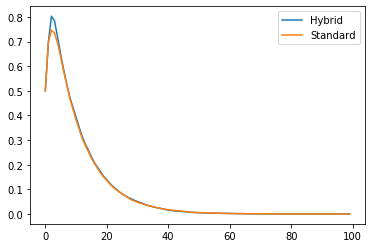

In [14]:
import matplotlib.pyplot as plt

plt.plot(hybrid['Infection Rates'], label='Hybrid')
plt.plot(standard['Infection Rates'], label='Standard')
plt.legend()